# GECO - Variational Autoencoder

The GECO-VAE is another extension upon the traditional VAE which is useful because it utilises user defined constraints to improve the optimisation. There are four constraints described within the paper but we will limit ourselves to the RE constraint in this example. 
The use of a constrained optimisation and Lagrange multiplier in this case enables a user to nominate a reconstruction error that is suficient for their problem and then benefit from improvement in the latent space distribution.



## Pytorch Implementation

Using pytorch and the mnist dataset.

Import everything:

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Lets use weights and bisases. You will need an account.
If running this on a cluster with jupyter nbconvert then you will have to add your wandb key as a environment variable in the container.

In [2]:
import wandb

Edit the below cell to setup project global variables

In [3]:
#Variables
batch_size = 128
learning_rate = 1e-4
epochs = 100
input_size = 28*28
latent_size = 2
hidden_size = 512
model_name = "model_z2_1.pth"
weights_name = "model_weights_z2_1.pth"

#GECO specific Parameters - values taken from those used in the paper.
K = 5.5
alpha = 0.99
lambda_update_freq = 100 #every 100 batch steps update lambda


wandb.init(project="GECO-VAE-MNIST",
           config={
               "batch_size": batch_size,
               "learning_rate": learning_rate,
               "dataset": "MNIST",
           })


# Get cpu or gpu device for training.
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

wandb: Currently logged in as: jcoll44 (use `wandb login --relogin` to force relogin)


Using cuda device


Now, let's set up our MNIST dataset. This is a simple setup and uses built in functions that can be found almost line-for-line in the pytorch quickstart guide

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

#Printing data
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    # print("Data Cross section: ", X[0,0,:,:])
    break

Shape of X [N, C, H, W]:  torch.Size([128, 1, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


Now to create a class for the encoder and decoder.

In [5]:
class EncoderNeuralNetwork(nn.Module):
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.network(x)
    
class DecoderNeuralNetwork(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),      
        )
        
    def forward(self, x):
        return self.network(x)

Now to instantiate our encoder and decoder classes to create a variational autoencoder.
Up until here it is pretty easy to follow. This next bit is where the magic happens.
Look for the RE_constraint() method and the forward() method that contain the GECO specific differences.

In [20]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.encoder = EncoderNeuralNetwork(input_size, hidden_size)
        self.decoder = DecoderNeuralNetwork(latent_size, hidden_size, input_size)
        
        # Parameters for decoding the output of the encoder
        self.fc_mu = nn.Linear(hidden_size, latent_size) #mu is the mean
        self.fc_var = nn.Linear(hidden_size, latent_size) #var is the variance
        
        #GECO specific values
        self.K = K #This is the reconstruction objective
        self.alpha = alpha
        self.lambda_update_freq = lambda_update_freq
        self.lambda_param = 1
        self.C_ma = 0
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def RE_constraint(self, x_hat, x):
        #Compute C_hat
        C_hat = torch.mean(torch.sum(torch.pow(torch.sub(x_hat,x),2),-1)-self.K**2)

        return C_hat

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl 
    
    def encode(self, x):
        #Encoder otherwise known as q. Pass x through it.
        encoded_x = self.encoder(x)
        
        #Use the encoding to find the mean and variance
        mu, log_var = self.fc_mu(encoded_x), self.fc_var(encoded_x)
        
        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        return z, mu, std
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x, iter_num=-1):

        #Encode x to find z
        z, mu, std = self.encode(x)
        
        # decode the latent space, otherwise known as the function p.
        # x_hat because this is the new x
        x_hat = self.decode(z)
        
        # Calculate the reconstruction constraint RE
        C_hat = self.RE_constraint(x_hat, x)
        
        if iter_num==0:
            #Initialise the moving average
            self.C_ma = C_hat
        elif iter_num>0:
            #Otherwise update the moving average
            self.C_ma = self.alpha*self.C_ma + (1-self.alpha)*C_hat

        #torch.no_grad() instead of StopGrad() as in paper
        with torch.no_grad():
            temp = (self.C_ma - C_hat)
        C_t = C_hat + temp 
        
        #Update lambda, this delayed update is not explicitly stated in the paper however
        #the authors code does do this intermitent update as it prevents the loss function 
        #getting exponentially large because of lambda. This is backed up by the clipping which
        #is also seen in the authors code.
        with torch.no_grad():
            if iter_num%self.lambda_update_freq==0:
                self.lambda_param = self.lambda_param*torch.clamp(torch.exp(C_t), 0.9, 1.1)

        # KL divergence
        kl = torch.mean(self.kl_divergence(z, mu, std))
        
        #GECO Loss
        loss = kl + self.lambda_param*C_hat
        
        
        return loss, kl, x_hat, self.lambda_param, self.C_ma, C_hat, z
    


Now that we have the VAE class we can go about setting up training and testing functions.
Unfortunately because of my attempt to keep all the VAE implementations similar we have to pass the current iteration number to the model, as stated before this helps to regulate the update frequency of lamda.

In [21]:
model = VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, optimizer, iter_num):
    size = len(dataloader.dataset)
    model.train()
    model.zero_grad()

    for (image, _) in dataloader:
    # for batch, (X, y) in enumerate(dataloader):
    
        # Compute prediction and loss
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        # X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        loss, kl, x_hat, lambda_param, C_ma, C_hat, z = model(image, iter_num)

        # Backpropagation
        loss.backward()
        optimizer.step()
        iter_num = iter_num+1
        
    return iter_num 
        
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    kl_loss= 0
    C_hat_loss= 0

    with torch.no_grad():
        for X, y in dataloader:
            image = X.reshape(-1, 28*28)
            image = image.to(device)
            loss, kl, x_hat, lambda_param, C_ma, C_hat, z = model(image)
            test_loss += loss
            kl_loss += kl
            C_hat_loss += C_hat
            
    
    test_loss_avg = test_loss/num_batches
    kl_loss /= num_batches
    C_hat_loss /= num_batches
    wandb.log({"loss": test_loss_avg, 
               "kl": kl_loss,
               "constraint": C_hat_loss,
               "lambda": lambda_param
              })
    wandb.watch(model)

    

VAE(
  (encoder): EncoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (decoder): DecoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (fc_mu): Linear(in_features=512, out_features=2, bias=True)
  (fc_var): Linear(in_features=512, out_features=2, bias=True)
)


Train our model and use the test dataset to plot the loss and other significant values.

In [22]:
%%wandb

#Timing the hardware difference
tic = time.perf_counter()

iter_num = 0

for t in range(epochs):
    iter_num  = train(train_dataloader, model, optimizer, iter_num)
    test(train_dataloader, model)
    if t%5==0:
        print(f"Epoch {t+1}\n-------------------------------")    
        # print(f"Avg loss: {test_loss_avg:>8f} \n")
print("Done!")

toc = time.perf_counter()
if {device} == "cpu":
    print(f"CPU time {toc - tic:0.4f} seconds")
else:
    print(f"GPU time {toc - tic:0.4f} seconds")

Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------
Epoch 51
-------------------------------
Epoch 56
-------------------------------
Epoch 61
-------------------------------
Epoch 66
-------------------------------
Epoch 71
-------------------------------
Epoch 76
-------------------------------
Epoch 81
-------------------------------
Epoch 86
-------------------------------
Epoch 91
-------------------------------
Epoch 96
-------------------------------
Done!
GPU time 926.3002 seconds


Now that we have trained our model we should save the model and the model weights.

In [23]:
torch.save(model, model_name)
torch.save(model.state_dict(), weights_name)

## Plotting and Visualisation

Lets begin our visualisation by plotting some randomly chosen numbers before reconstruction and after reconstruction.

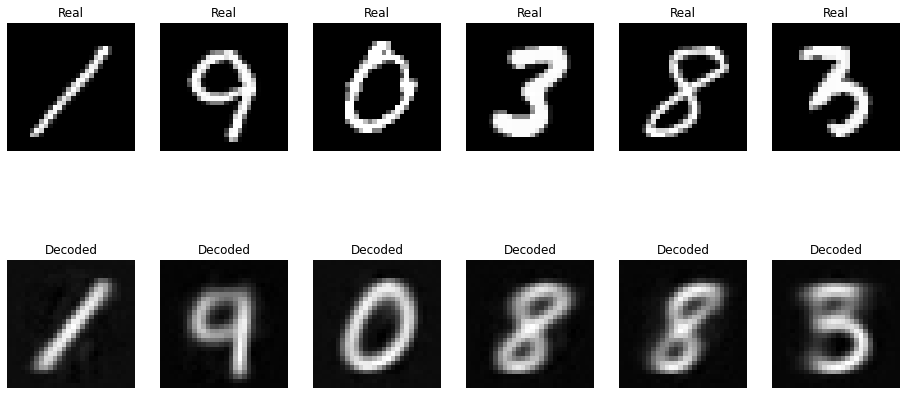

In [24]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 2
for i in range(1, cols +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    image = img.reshape(-1, 28*28)
    image = image.to(device)
    loss, kl, x_hat, lambda_param, C_ma, C_hat, z = model(image)
    pred = x_hat.to("cpu")
    pred = pred.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title("Real")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, i+cols)
    plt.title("Decoded")
    plt.axis("off")
    plt.imshow(pred.reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
plt.show()

Now lets investigate the latent space further. The plot below shows the latent space and where different MNIST numbers are located within it. They should be clustered by their number and centrally located around 0 as we directed them to be.

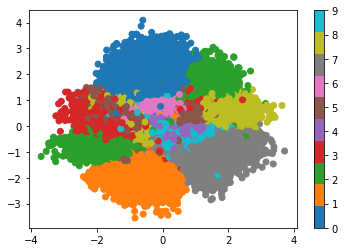

In [25]:
def plot_latent(model, dataloader, num_batches=100):
    for (image, y) in dataloader:
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        loss, kl, x_hat, lambda_param, C_ma, C_hat, z = model(image)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

    plt.colorbar()
            
plot_latent(model, train_dataloader)

Now lets do a linear interpolation between all the number, i.e. 1->2, 2->3 etc.
We can do this by taking the latent space of 2 numbers (e.g. 1 and 2) and calculating the latent vector halfway between them.

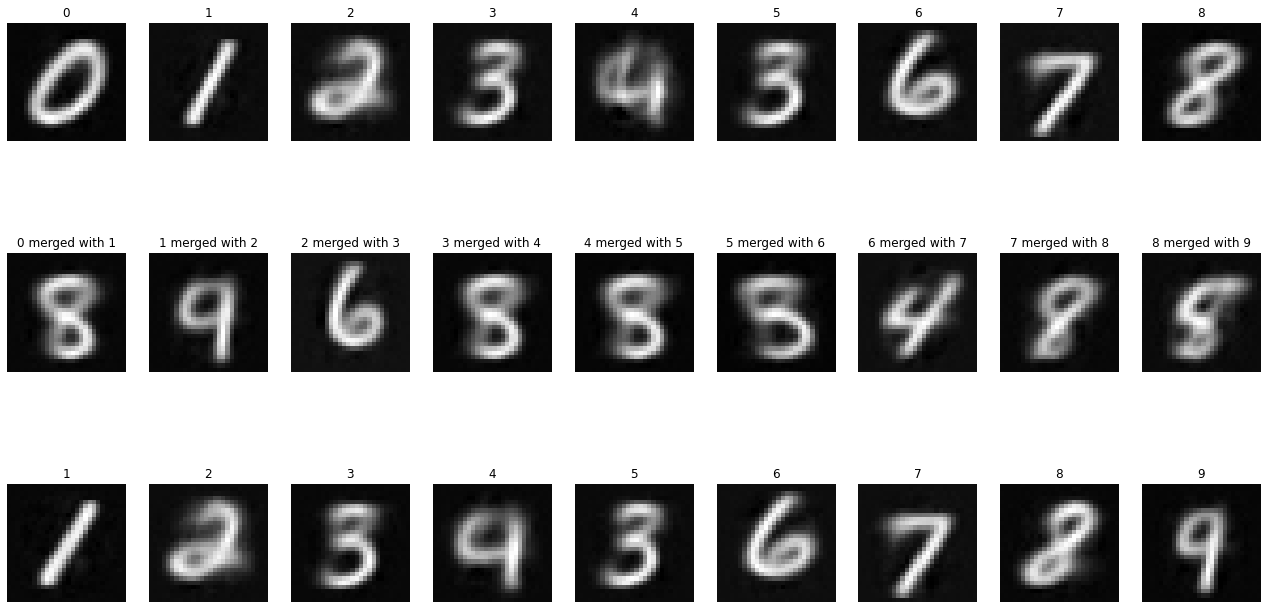

In [26]:
number_array = []
figure = plt.figure(figsize=(25, 12))
cols, rows = 10 , 3

for k in range(10):
    for (image, y) in training_data:
        if y==k:
            number_array.append(image)
            break
    
for l in range(1,10):
    number_a = number_array[l-1].reshape(-1, 28*28)
    number_a = number_a.to(device)
    loss, kl, x_hat_a, lambda_param, C_ma, C_hat, z_a = model(number_a)
    
    number_b = number_array[l].reshape(-1, 28*28)
    number_b = number_b.to(device)
    loss, kl, x_hat_b, lambda_param, C_ma, C_hat, z_b = model(number_b)
    
    figure.add_subplot(rows, cols, l)
    plt.title(str(l-1))
    plt.axis("off")
    plt.imshow(x_hat_a.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
    figure.add_subplot(rows, cols, l+(cols*2))
    plt.title(str(l))
    plt.axis("off")
    plt.imshow(x_hat_b.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
    z_c = z_a*0.5 + z_b*0.5
    number_c = z_c.to(device)
    x_hat = model.decode(number_c)
    figure.add_subplot(rows, cols, l+(cols))
    plt.title(str(l-1)+" merged with "+str(l))
    plt.axis("off")
    plt.imshow(x_hat.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
plt.show()

For our last visualisation lets produce a square "walk" around the latent space. This is similar to the plot_latent() function above although with images rather than a scatter plot.

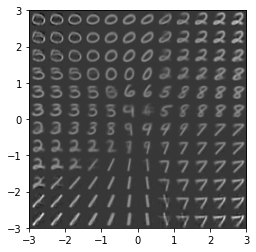

In [27]:
def plot_reconstructed(autoencoder, r0=(-6, 5), r1=(-6, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap="gray")
    
plot_reconstructed(model, (-3, 3), (-3, 3), 12)

If we wanted to reload the model at a latter date we could do so with the code below. Just make sure to run the classes up above first.

In [28]:
# Model class must be defined somewhere
model2 = torch.load(model_name)
model2.load_state_dict(torch.load(weights_name))
model2.eval()


VAE(
  (encoder): EncoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (decoder): DecoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (fc_mu): Linear(in_features=512, out_features=2, bias=True)
  (fc_var): Linear(in_features=512, out_features=2, bias=True)
)